In [1]:
import torch


In [2]:
"""
Deep Q Network
"""
import argparse
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple

import numpy as np
import pytorch_lightning as pl
import torch
from pytorch_lightning import seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from torch import optim as optim
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader

from pl_bolts.datamodules.experience_source import Experience, ExperienceSourceDataset
from pl_bolts.losses.rl import dqn_loss
from pl_bolts.models.rl.common.gym_wrappers import make_environment
from pl_bolts.models.rl.common.memory import MultiStepBuffer
from pl_bolts.models.rl.common.networks import CNN

from gym import Env

from abc import ABC
from typing import List

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F

from functools import partial
import collections

import torchfunc



class Agent(ABC):
    """Basic agent that always returns 0"""

    def __init__(self, net: nn.Module):
        self.net = net

    def __call__(self, state: torch.Tensor, device: str, *args, **kwargs) -> List[int]:
        """
        Using the given network, decide what action to carry
        Args:
            state: current state of the environment
            device: device used for current batch
        Returns:
            action
        """
        return [0]

class ValueAgent_(Agent):
    """Value based agent that returns an action based on the Q values from the network"""

    def __init__(
        self,
        net: nn.Module,
        action_space: int,
        eps_start: float = 1.0,
        eps_end: float = 0.2,
        eps_frames: float = 1000,
    ):
        super().__init__(net)
        self.action_space = action_space
        self.eps_start = eps_start
        self.epsilon = eps_start
        self.eps_end = eps_end
        self.eps_frames = eps_frames
        self.recorder=torchfunc.hooks.recorders.ForwardPre()
        self.recorder.modules(self.net)

    @torch.no_grad()
    def __call__(self, state: torch.Tensor, device: str) -> List[int]:
        """
        Takes in the current state and returns the action based on the agents policy
        Args:
            state: current state of the environment
            device: the device used for the current batch
        Returns:
            action defined by policy
        """
        if not isinstance(state, list):
            state = [state]

        if np.random.random() < self.epsilon:
            action = self.get_random_action(state)
        else:
            action = self.get_action(state, device)
        

        return action

    def get_random_action(self, state: torch.Tensor) -> int:
        """returns a random action"""
        actions = []

        for i in range(len(state)):
            action = np.random.randint(0, self.action_space)
            actions.append(action)

        return actions

    def get_action(self, state: torch.Tensor, device: torch.device):
        """
        Returns the best action based on the Q values of the network
        Args:
            state: current state of the environment
            device: the device used for the current batch
        Returns:
            action defined by Q values
        """
        if not isinstance(state, torch.Tensor):
            state = torch.tensor(state, device=device)

        q_values = self.net(state)
    
        _, actions = torch.max(q_values, dim=1)
        return actions.detach().cpu().numpy()

    def update_epsilon(self, step: int) -> None:
        """
        Updates the epsilon value based on the current step
        Args:
            step: current global step
        """
        self.epsilon = max(self.eps_end, self.eps_start - (step + 1) / self.eps_frames)
    

class DQN_(pl.LightningModule):
    """
    Basic DQN Model

    PyTorch Lightning implementation of `DQN <https://arxiv.org/abs/1312.5602>`_
    Paper authors: Volodymyr Mnih, Koray Kavukcuoglu, David Silver, Alex Graves,
    Ioannis Antonoglou, Daan Wierstra, Martin Riedmiller.
    Model implemented by:

        - `Donal Byrne <https://github.com/djbyrne>`

    Example:
        >>> from pl_bolts.models.rl.dqn_model import DQN
        ...
        >>> model = DQN("PongNoFrameskip-v4")

    Train::

        trainer = Trainer()
        trainer.fit(model)

    Note:
        This example is based on:
        https://github.com/PacktPublishing/Deep-Reinforcement-Learning-Hands-On-Second-Edition/blob/master/Chapter06/02_dqn_pong.py

    Note:
        Currently only supports CPU and single GPU training with `distributed_backend=dp`
    """

    def __init__(
        self,
        env: str,
        eps_start: float = 1.0,
        eps_end: float = 0.02,
        eps_last_frame: int = 150000,
        sync_rate: int = 1000,
        gamma: float = 0.99,
        learning_rate: float = 1e-4,
        batch_size: int = 32,
        replay_size: int = 100000,
        warm_start_size: int = 10000,
        avg_reward_len: int = 100,
        min_episode_reward: int = -21,
        seed: int = 123,
        batches_per_epoch: int = 1000,
        n_steps: int = 1,
        **kwargs,
    ):
        """
        Args:
            env: gym environment tag
            eps_start: starting value of epsilon for the epsilon-greedy exploration
            eps_end: final value of epsilon for the epsilon-greedy exploration
            eps_last_frame: the final frame in for the decrease of epsilon. At this frame espilon = eps_end
            sync_rate: the number of iterations between syncing up the target network with the train network
            gamma: discount factor
            learning_rate: learning rate
            batch_size: size of minibatch pulled from the DataLoader
            replay_size: total capacity of the replay buffer
            warm_start_size: how many random steps through the environment to be carried out at the start of
                training to fill the buffer with a starting point
            avg_reward_len: how many episodes to take into account when calculating the avg reward
            min_episode_reward: the minimum score that can be achieved in an episode. Used for filling the avg buffer
                before training begins
            seed: seed value for all RNG used
            batches_per_epoch: number of batches per epoch
            n_steps: size of n step look ahead
        """
        super().__init__()

        # Environment
        self.exp = None
        self.env = self.make_environment(env, seed)
        self.test_env = self.make_environment(env)

        self.obs_shape = self.env.observation_space.shape
        self.n_actions = self.env.action_space.n

        # Model Attributes
        self.buffer = None
        self.dataset = None

        self.net = None
        self.target_net = None
        self.build_networks()

        self.agent = ValueAgent_(
            self.net,
            self.n_actions,
            eps_start=eps_start,
            eps_end=eps_end,
            eps_frames=eps_last_frame,
        )

        # Hyperparameters
        self.sync_rate = sync_rate
        self.gamma = gamma
        self.lr = learning_rate
        self.batch_size = batch_size
        self.replay_size = replay_size
        self.warm_start_size = warm_start_size
        self.batches_per_epoch = batches_per_epoch
        self.n_steps = n_steps

        self.save_hyperparameters()

        # Metrics
        self.total_episode_steps = [0]
        self.total_rewards = [0]
        self.done_episodes = 0
        self.total_steps = 0

        # Average Rewards
        self.avg_reward_len = avg_reward_len

        for _ in range(avg_reward_len):
            self.total_rewards.append(torch.tensor(min_episode_reward, device=self.device))

        self.avg_rewards = float(np.mean(self.total_rewards[-self.avg_reward_len:]))

        self.state = self.env.reset()

    def run_n_episodes(self, env, n_epsiodes: int = 1, epsilon: float = 1.0) -> List[int]:
        """
        Carries out N episodes of the environment with the current agent

        Args:
            env: environment to use, either train environment or test environment
            n_epsiodes: number of episodes to run
            epsilon: epsilon value for DQN agent
        """
        total_rewards = []
        self.im_arr=[]
        for _ in range(n_epsiodes):
            episode_state = env.reset()
            done = False
            episode_reward = 0

            while not done:
                self.agent.epsilon = epsilon
                action = self.agent(episode_state, self.device)
                #print(action)
                import matplotlib.pyplot as plt
                #plt.imshow(episode_state[0,:,:])
                #plt.show()
                self.im_arr.append(np.mean(episode_state,axis=0).flatten())
                next_state, reward, done, _ = env.step(action[0])
                episode_state = next_state
                episode_reward += reward

            total_rewards.append(episode_reward)
            self.activations=self.agent.recorder.data
        self.im_arr=np.array(self.im_arr)
        return total_rewards

    def populate(self, warm_start: int) -> None:
        """Populates the buffer with initial experience"""
        if warm_start > 0:
            self.state = self.env.reset()

            for _ in range(warm_start):
                self.agent.epsilon = 1.0
                action = self.agent(self.state, self.device)
                #print(action)
                next_state, reward, done, _ = self.env.step(action[0])
                exp = Experience(state=self.state, action=action[0], reward=reward, done=done, new_state=next_state)
                self.buffer.append(exp)
                self.state = next_state

                if done:
                    self.state = self.env.reset()

    def build_networks(self) -> None:
        """Initializes the DQN train and target networks"""
        self.net = CNN(self.obs_shape, self.n_actions)
        self.target_net = CNN(self.obs_shape, self.n_actions)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Passes in a state x through the network and gets the q_values of each action as an output

        Args:
            x: environment state

        Returns:
            q values
        """
        output = self.net(x)
        return output

    def train_batch(self, ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Contains the logic for generating a new batch of data to be passed to the DataLoader

        Returns:
            yields a Experience tuple containing the state, action, reward, done and next_state.
        """
        episode_reward = 0
        episode_steps = 0

        while True:
            self.total_steps += 1
            action = self.agent(self.state, self.device)

            next_state, r, is_done, _ = self.env.step(action[0])

            episode_reward += r
            episode_steps += 1

            exp = Experience(state=self.state, action=action[0], reward=r, done=is_done, new_state=next_state)

            self.agent.update_epsilon(self.global_step)
            self.buffer.append(exp)
            self.state = next_state

            if is_done:
                self.done_episodes += 1
                self.total_rewards.append(episode_reward)
                self.total_episode_steps.append(episode_steps)
                self.avg_rewards = float(np.mean(self.total_rewards[-self.avg_reward_len:]))
                self.state = self.env.reset()
                episode_steps = 0
                episode_reward = 0

            states, actions, rewards, dones, new_states = self.buffer.sample(self.batch_size)

            for idx, _ in enumerate(dones):
                yield states[idx], actions[idx], rewards[idx], dones[idx], new_states[idx]

            # Simulates epochs
            if self.total_steps % self.batches_per_epoch == 0:
                break

    def training_step(self, batch: Tuple[torch.Tensor, torch.Tensor], _) -> OrderedDict:
        """
        Carries out a single step through the environment to update the replay buffer.
        Then calculates loss based on the minibatch recieved

        Args:
            batch: current mini batch of replay data
            _: batch number, not used

        Returns:
            Training loss and log metrics
        """

        # calculates training loss
        loss = dqn_loss(batch, self.net, self.target_net)

        if self.trainer.use_dp or self.trainer.use_ddp2:
            loss = loss.unsqueeze(0)

        # Soft update of target network
        if self.global_step % self.sync_rate == 0:
            self.target_net.load_state_dict(self.net.state_dict())

        self.log_dict({
            "total_reward": self.total_rewards[-1],
            "avg_reward": self.avg_rewards,
            "train_loss": loss,
            "episodes": self.done_episodes,
            "episode_steps": self.total_episode_steps[-1]
        })

        return OrderedDict({
            "loss": loss,
            "avg_reward": self.avg_rewards,
        })

    def test_step(self, *args, **kwargs) -> Dict[str, torch.Tensor]:
        """Evaluate the agent for 10 episodes"""
        test_reward = self.run_n_episodes(self.test_env, 1, 0)
        avg_reward = sum(test_reward) / len(test_reward)
        return {"test_reward": avg_reward}

    def test_epoch_end(self, outputs) -> Dict[str, torch.Tensor]:
        """Log the avg of the test results"""
        rewards = [x["test_reward"] for x in outputs]
        avg_reward = sum(rewards) / len(rewards)
        self.log("avg_test_reward", avg_reward)
        return {"avg_test_reward": avg_reward}

    def configure_optimizers(self) -> List[Optimizer]:
        """ Initialize Adam optimizer"""
        optimizer = optim.Adam(self.net.parameters(), lr=self.lr)
        return [optimizer]

    def _dataloader(self) -> DataLoader:
        """Initialize the Replay Buffer dataset used for retrieving experiences"""
        self.buffer = MultiStepBuffer(self.replay_size, self.n_steps)
        self.populate(self.warm_start_size)

        self.dataset = ExperienceSourceDataset(self.train_batch)
        return DataLoader(dataset=self.dataset, batch_size=self.batch_size)

    def train_dataloader(self) -> DataLoader:
        """Get train loader"""
        return self._dataloader()

    def test_dataloader(self) -> DataLoader:
        """Get test loader"""
        return self._dataloader()

    @staticmethod
    def make_environment(env_name: str, seed: Optional[int] = None) -> Env:
        """
        Initialise gym  environment

        Args:
            env_name: environment name or tag
            seed: value to seed the environment RNG for reproducibility

        Returns:
            gym environment
        """
        env = make_environment(env_name)

        if seed:
            env.seed(seed)

        return env

    @staticmethod
    def add_model_specific_args(arg_parser: argparse.ArgumentParser, ) -> argparse.ArgumentParser:
        """
        Adds arguments for DQN model

        Note:
            These params are fine tuned for Pong env.

        Args:
            arg_parser: parent parser
        """
        arg_parser.add_argument(
            "--sync_rate",
            type=int,
            default=1000,
            help="how many frames do we update the target network",
        )
        arg_parser.add_argument(
            "--replay_size",
            type=int,
            default=100000,
            help="capacity of the replay buffer",
        )
        arg_parser.add_argument(
            "--warm_start_size",
            type=int,
            default=10000,
            help="how many samples do we use to fill our buffer at the start of training",
        )
        arg_parser.add_argument(
            "--eps_last_frame",
            type=int,
            default=150000,
            help="what frame should epsilon stop decaying",
        )
        arg_parser.add_argument("--eps_start", type=float, default=1.0, help="starting value of epsilon")
        arg_parser.add_argument("--eps_end", type=float, default=0.02, help="final value of epsilon")
        arg_parser.add_argument("--batches_per_epoch", type=int, default=10000, help="number of batches in an epoch")
        arg_parser.add_argument("--batch_size", type=int, default=32, help="size of the batches")
        arg_parser.add_argument("--lr", type=float, default=1e-4, help="learning rate")

        arg_parser.add_argument("--env", type=str, required=True, help="gym environment tag")
        arg_parser.add_argument("--gamma", type=float, default=0.99, help="discount factor")

        arg_parser.add_argument(
            "--avg_reward_len",
            type=int,
            default=100,
            help="how many episodes to include in avg reward",
        )
        arg_parser.add_argument(
            "--n_steps",
            type=int,
            default=1,
            help="how many frames do we update the target network",
        )

        return arg_parser
    


def cli_main():
    parser = argparse.ArgumentParser(add_help=False)

    # trainer args
    parser = pl.Trainer.add_argparse_args(parser)

    # model args
    parser = DQN.add_model_specific_args(parser)
    args = parser.parse_args()

    model = DQN(**args.__dict__)

    # save checkpoints based on avg_reward
    checkpoint_callback = ModelCheckpoint(save_top_k=1, monitor="avg_reward", mode="max", period=1, verbose=True)

    seed_everything(123)
    trainer = pl.Trainer.from_argparse_args(args, deterministic=True, checkpoint_callback=checkpoint_callback)

    trainer.fit(model)



In [3]:
rl_net=DQN_("DemonAttack-v0")

In [4]:
PATH='C:/Users/koester_lab/Documents/Maria/UdacityMachineLearningEngineerNanoDegree/dqn_model.pth'
rl_net.net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [5]:
PATH='C:/Users/koester_lab/Documents/Maria/UdacityMachineLearningEngineerNanoDegree/dqn_target_model.pth'
rl_net.target_net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [6]:
env="DemonAttack-v0"
rl_net.run_n_episodes(env=rl_net.env,n_epsiodes=3,epsilon=0.0)

[140.0, 840.0, 100.0]

In [7]:
print(rl_net.net)

CNN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (head): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)


In [16]:
print(rl_net.im_arr.shape)

(1386, 7056)


In [19]:
print(len(rl_net.activations[6]))

1386


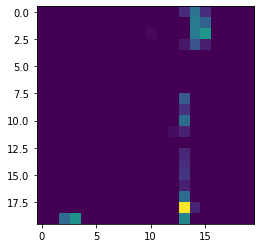

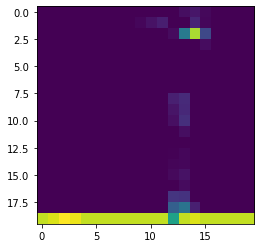

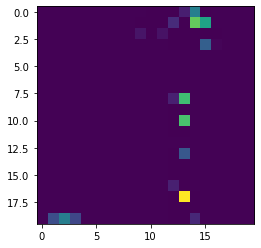

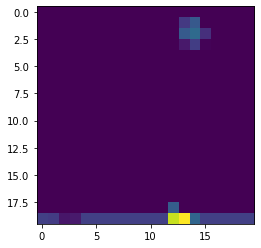

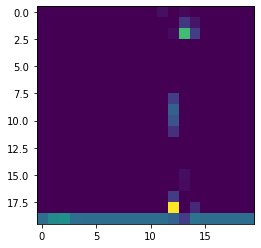

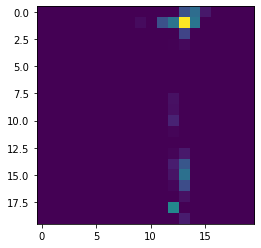

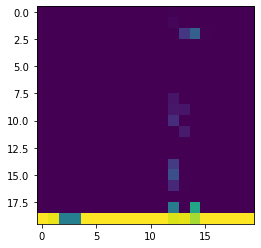

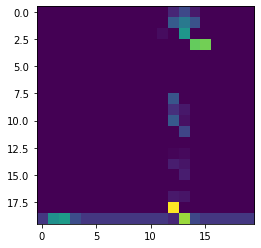

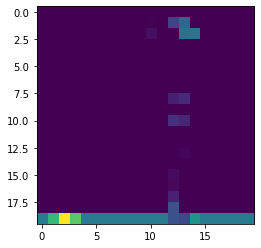

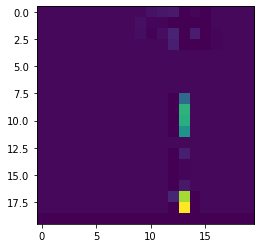

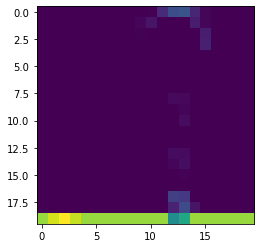

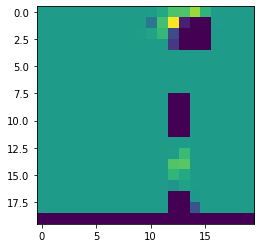

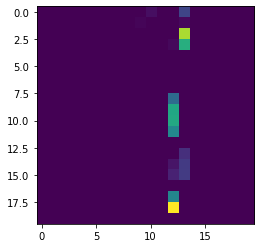

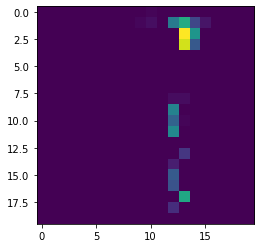

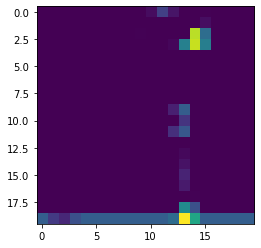

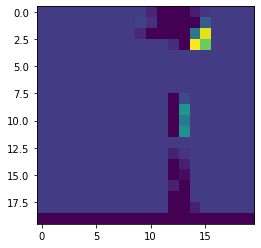

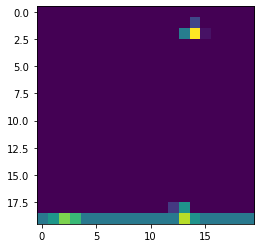

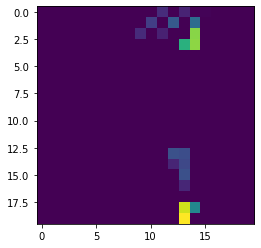

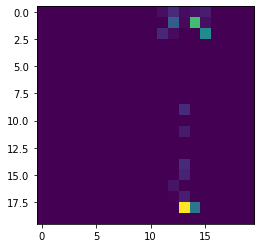

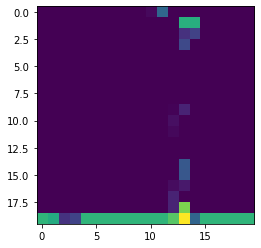

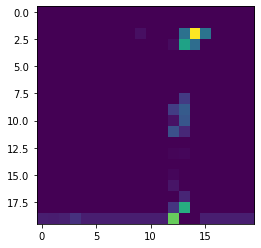

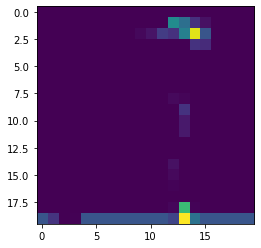

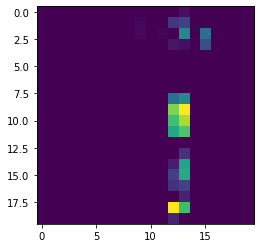

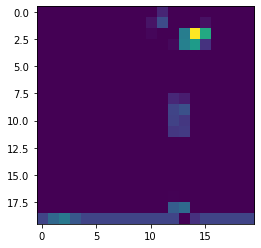

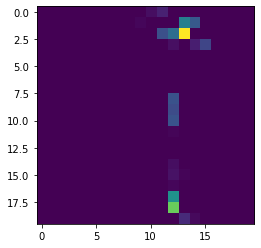

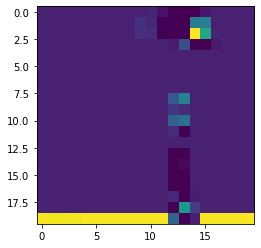

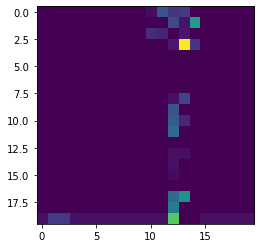

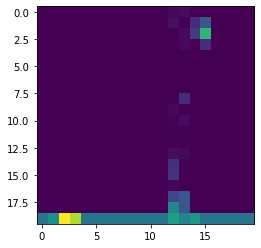

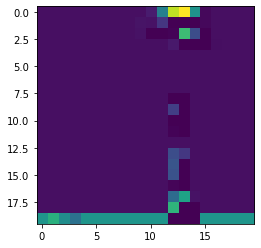

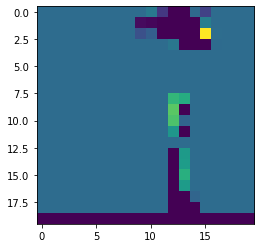

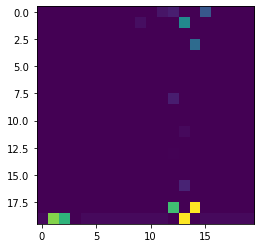

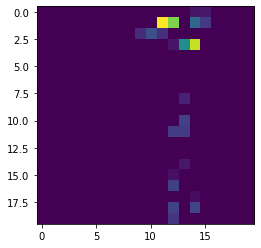

In [9]:
for l in range(0,32):
    import matplotlib.pyplot as plt
    plt.imshow(rl_net.activations[4][100][0,l,:])
    plt.show()

In [10]:
for i, submodule in enumerate(rl_net.net.modules()):
    print(i, submodule)

0 CNN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (head): Sequential(
    (0): Linear(in_features=3136, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=6, bias=True)
  )
)
1 Sequential(
  (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
  (1): ReLU()
  (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
  (3): ReLU()
  (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
  (5): ReLU()
)
2 Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
3 ReLU()
4 Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
5 ReLU()
6 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
7 ReLU()
8 Sequential(
  (0): Linear(in_features=3136, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=6, bias=True)
)
9 Linear(in_featu

# Dimensionality Reduction

In [21]:
t_arr=np.zeros((64*9*9,1386))
for j in range(0,1386):
    t_arr[:,j]=rl_net.activations[6][j].flatten()

In [12]:
from sklearn.decomposition import PCA

pca=PCA(n_components=10)
V=pca.fit_transform(t_arr)
print(V.shape)

(5184, 10)


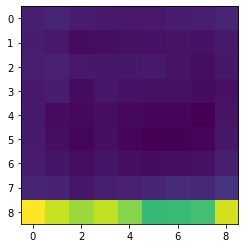

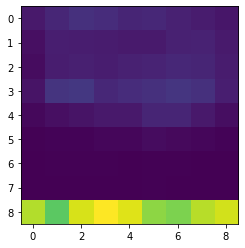

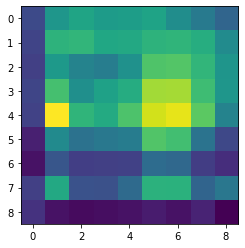

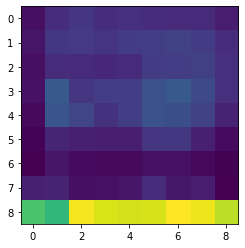

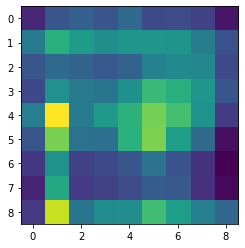

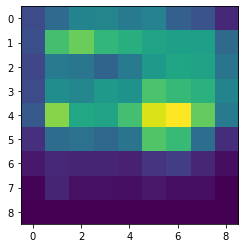

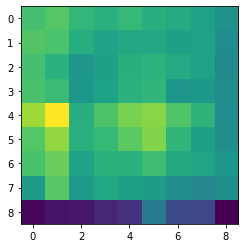

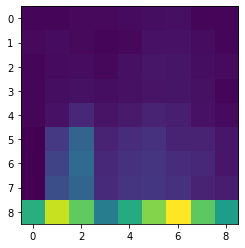

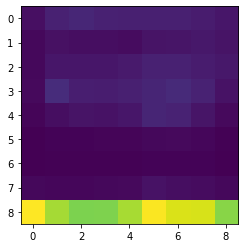

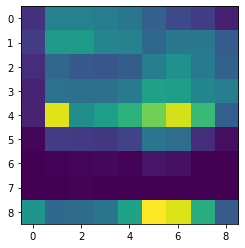

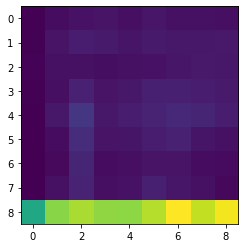

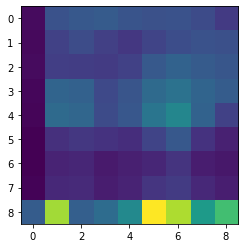

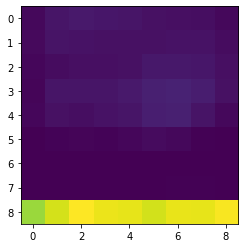

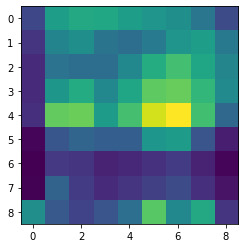

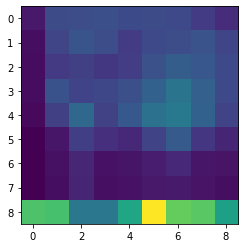

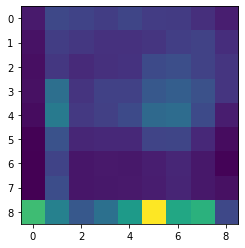

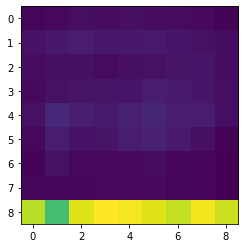

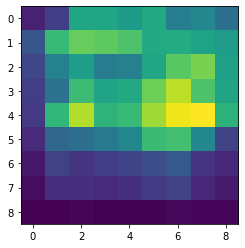

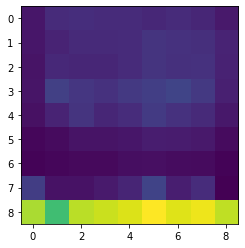

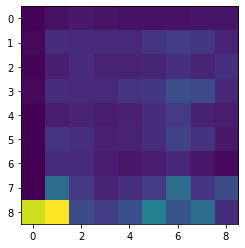

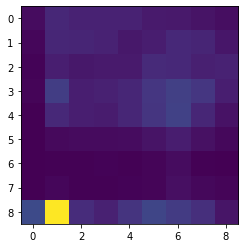

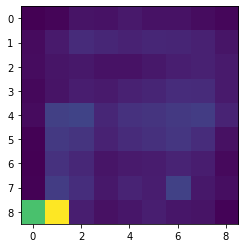

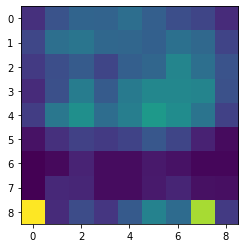

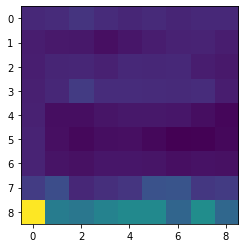

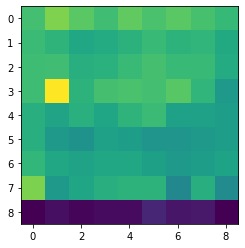

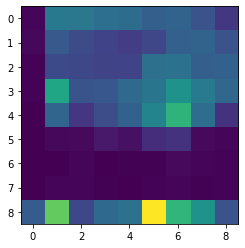

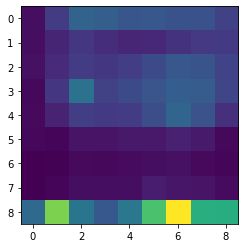

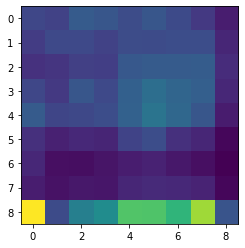

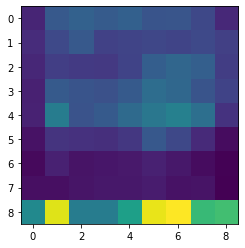

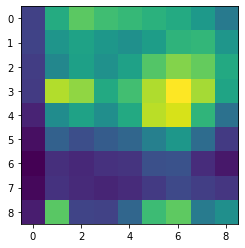

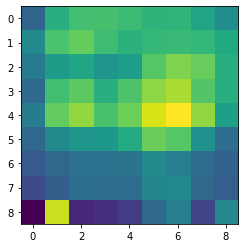

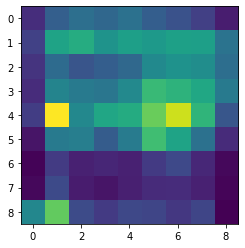

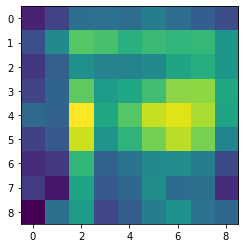

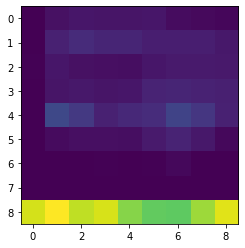

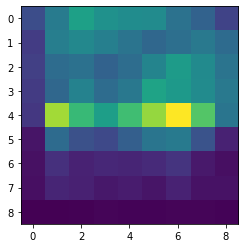

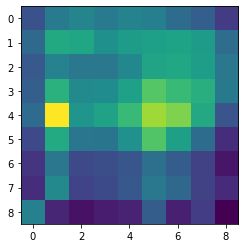

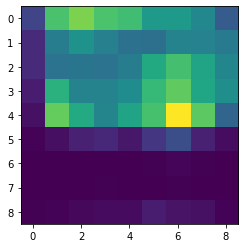

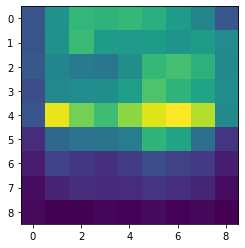

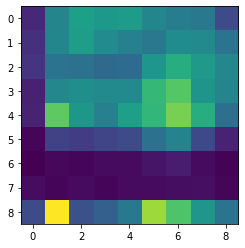

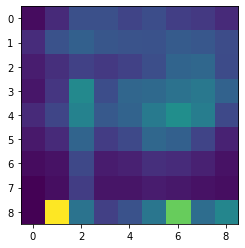

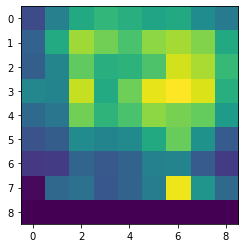

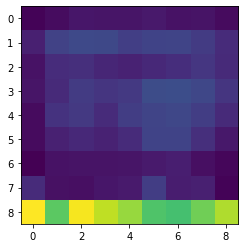

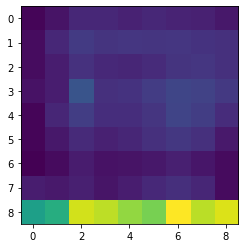

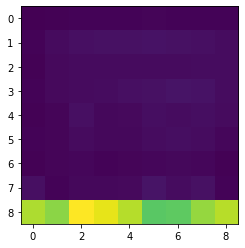

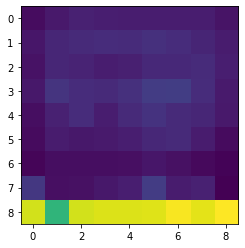

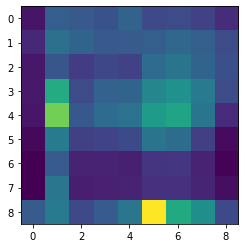

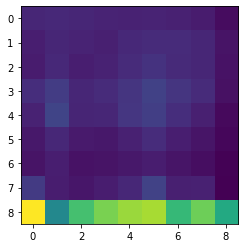

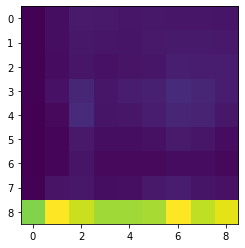

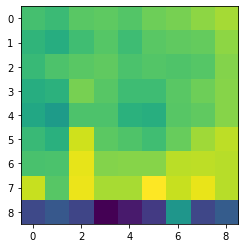

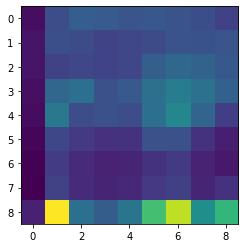

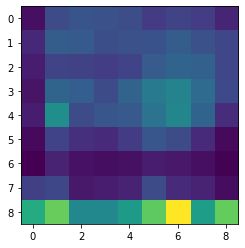

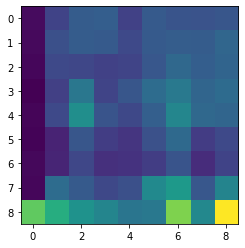

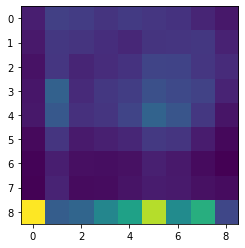

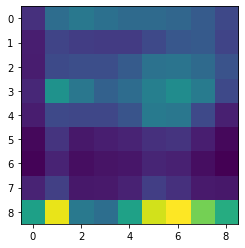

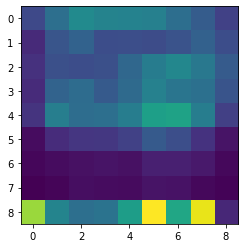

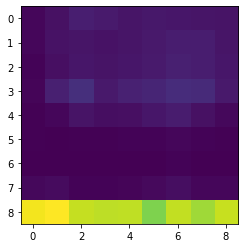

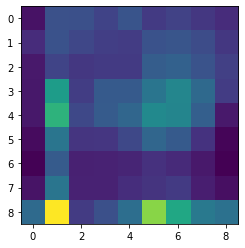

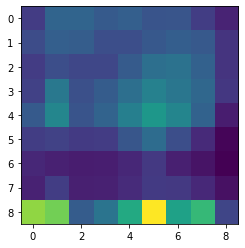

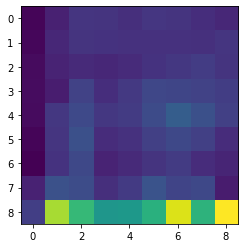

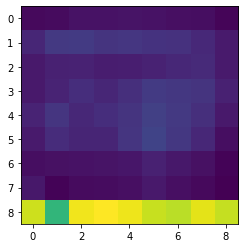

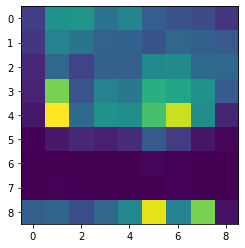

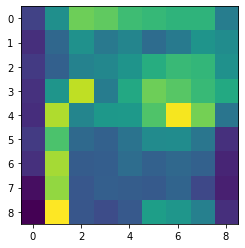

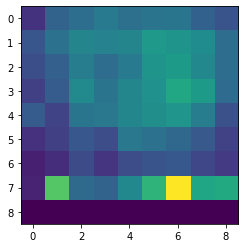

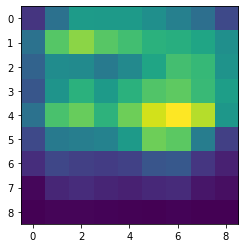

In [13]:
eigens=V.reshape(64,9,9,10)
for l in range(0,64):
    import matplotlib.pyplot as plt
    plt.imshow(eigens[l,:,:,1])
    plt.show()

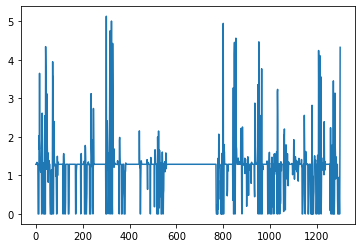

In [14]:
plt.plot(t_arr[1])

In [22]:
print(t_arr.shape)

(5184, 1386)


# Regression

In [35]:
from EnsemblePursuit.EnsemblePursuit import EnsemblePursuit
def compute_rfield(imgs,V):
    imgs=imgs.T
    lam=10
    npix=84*84
    B0 = np.linalg.solve((imgs @ imgs.T + lam * np.eye(npix)),  (imgs @ V)).reshape(84,84,15)
    return B0

def receptive_fields_of_ind_layers(t_arr,imgs):
    neurons=t_arr.T
    ep=EnsemblePursuit(n_components=15,n_kmeans=15,lam=0.1)
    ep.fit(neurons)
    V=ep.components_
    U=ep.weights.flatten()
    B0=compute_rfield(imgs,V)
    for j in range(0,15):
        n_neurons=np.nonzero(ep.weights[:,j].flatten())[0].shape[0]
        plt.imshow(B0[:,:,j],cmap='bwr')
        plt.title('Ensemble '+str(j)+', n_neurons='+str(n_neurons))
        plt.show()

In [28]:
rl_net.im_arr.shape

(1386, 7056)

In [29]:
84*84

7056

obtained 15 PCs in 0.1425 seconds
initialized 15 clusters with k-means in 0.3018 seconds
ensemble 0, time 0.26, nr neurons 581, EV 0.0324
ensemble 14, time 2.08, nr neurons 177, EV 0.2014
average sparsity is 0.0552


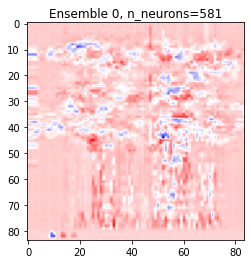

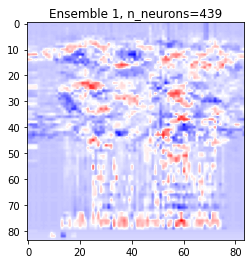

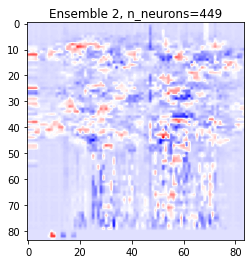

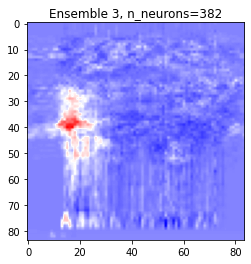

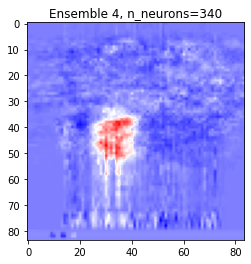

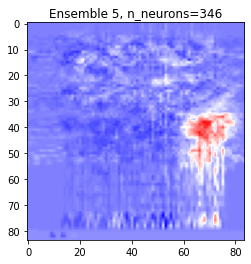

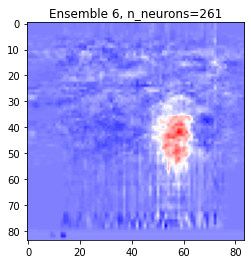

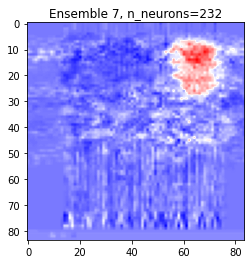

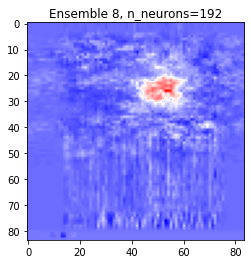

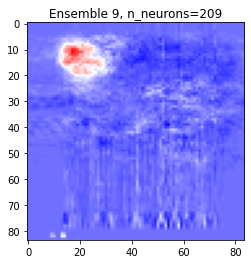

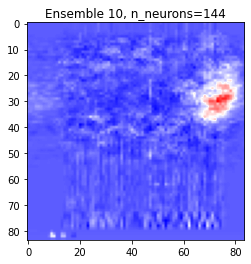

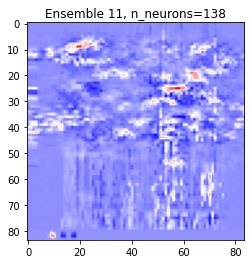

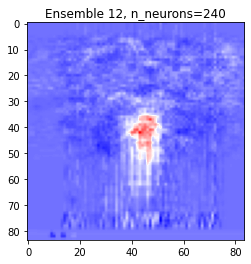

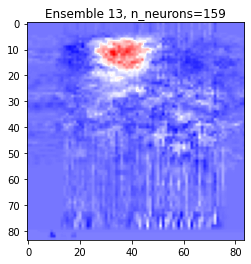

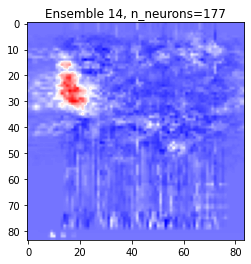

In [36]:
receptive_fields_of_ind_layers(t_arr,rl_net.im_arr)